# Кластеры

## Описание данных

В файле Worldbank_tech.csv содержаться данные Всемирного банка по ряду показателей за 2015 год. В файле следующие переменные:
    
    - country_name: Country Name
    - country_code: Country Code
    - internet: Internet users (per 100 people)
    - secure: Secure Internet servers (per 1 million people)
    - export: Communications, computer, etc. (% of service exports)
    - import: Communications, computer, etc. (% of service imports)
    - telephone: Fixed telephone subscriptions (per 100 people)
    - hightech: High-technology exports (current US$)
    - mobile: Mobile cellular subscriptions (per 100 people)
    



## Иерархический кластерный анализ

Исследуем следующие метрические переменные:

In [21]:
metric_vars = ['internet', 'secure', 'telephone', 'mobile']

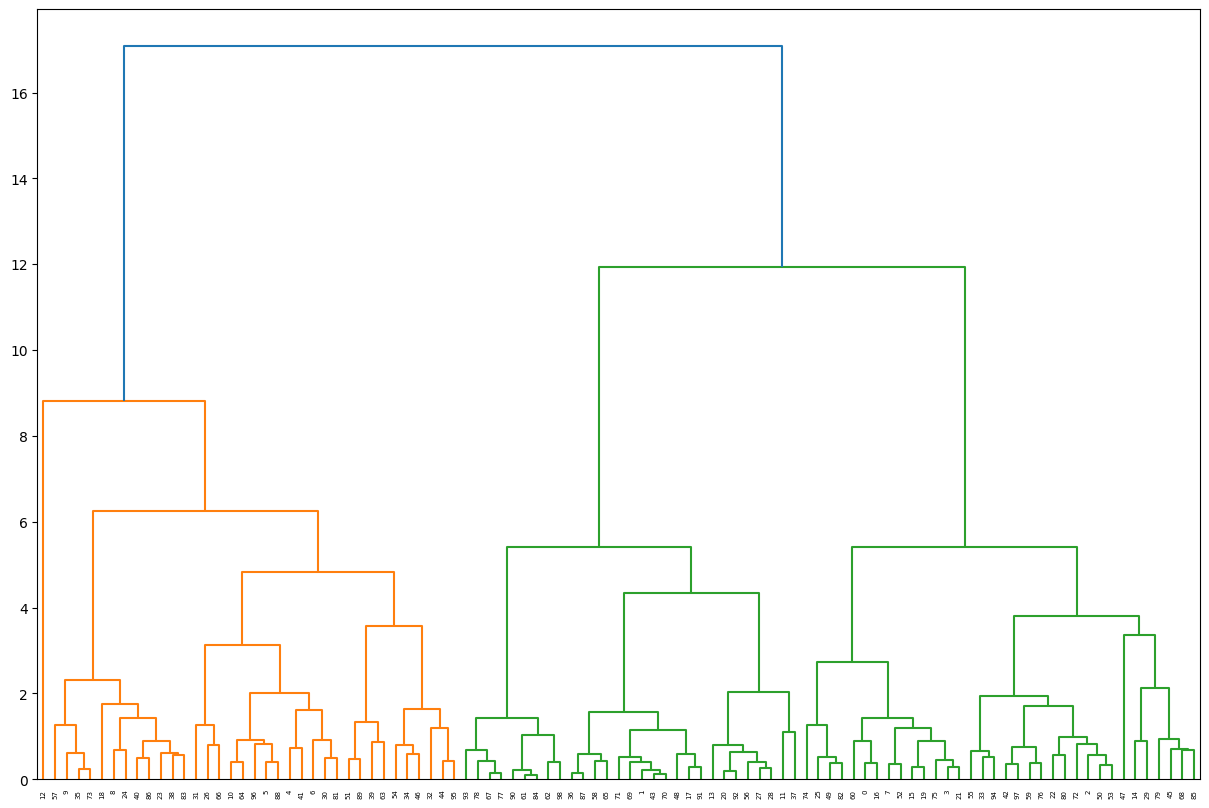

In [22]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt


df = pd.read_csv('csv_files/Worldbank_tech.csv', sep=';')
df = df.dropna()
for i in metric_vars:
    df['z_' + i] = (df[i] - df[i].mean()) / df[i].std()

metric_vars_norm = list(map(lambda x: 'z_' + x, metric_vars))
plt.figure(figsize=(15, 10))
dn = dendrogram(linkage(df[metric_vars_norm], 'ward')) # используем метод Варда, т.к. он минимизирует внутрикластерный разброс

Дендрограмма получилась не самая однозначная, сложно визуально определить количество кластеров, кейсы распределены почти равномерно.

### Вычислим индекс Калински–Харабаша

In [23]:
from sklearn.metrics import calinski_harabasz_score
Z = linkage(df[metric_vars_norm], method='ward', metric='euclidean')

for k in range (2, 10):
    labels = fcluster(Z, t=k, criterion='maxclust')
    print('Число кластеров: {}, индекс {}'.format(k, calinski_harabasz_score(df[metric_vars_norm], labels)))

Число кластеров: 2, индекс 57.55697345701381
Число кластеров: 3, индекс 59.63494326175001
Число кластеров: 4, индекс 59.65229280948811
Число кластеров: 5, индекс 55.6469384584428
Число кластеров: 6, индекс 53.046273243371054
Число кластеров: 7, индекс 53.614828964197585
Число кластеров: 8, индекс 54.48373711223876
Число кластеров: 9, индекс 55.48139162166415


Максимальное расстояние при 4-х кластерах $⟹$ берем 4 кластера.

In [24]:
labels = fcluster(Z, t=4, criterion='maxclust') #проводим расчёты для 4-х кластеров
df['culster_labels'] = labels
df.groupby('culster_labels')[metric_vars].mean()

,internet,secure,telephone,mobile
culster_labels,,,,
1,82.609582,1258.358820,40.591920,120.694216
2,98.323610,7204.721392,18.298820,57.946262
3,33.265935,35.145877,7.994002,92.723449
4,63.048928,175.557576,17.601072,142.698217


In [25]:
for i in range (1, 5):
    print("Кластер {}".format(i))
    print(df[df['culster_labels'] == i][["country_name"]].to_numpy().flatten())

Кластер 1
['Aruba' 'Australia' 'Austria' 'Bahamas, The' 'Belarus' 'Belgium' 'Canada'
 'Croatia' 'Cyprus' 'Denmark' 'Estonia' 'Finland' 'France' 'Germany'
 'Greece' 'Hungary' 'Iceland' 'Ireland' 'Israel' 'Japan' 'Korea, Rep.'
 'Luxembourg' 'Malta' 'Moldova' 'Netherlands' 'New Zealand' 'Norway'
 'Portugal' 'Singapore' 'Slovenia' 'Spain' 'Sweden' 'Switzerland'
 'United Kingdom' 'United States']
Кластер 2
['Bermuda']
Кластер 3
['Algeria' 'Belize' 'Bosnia and Herzegovina' 'Cabo Verde' 'China'
 'Dominican Republic' 'Ecuador' 'Guatemala' 'Guyana' 'Jamaica'
 'Kyrgyz Republic' 'Mexico' 'Mongolia' 'Mozambique' 'Nepal' 'Nicaragua'
 'Pakistan' 'Paraguay' 'Peru' 'Philippines' 'Rwanda'
 'Sao Tome and Principe' 'Solomon Islands' 'Sri Lanka' 'Tanzania'
 'Thailand' 'Turkey' 'Uganda' 'Zimbabwe']
Кластер 4
['Albania' 'Argentina' 'Armenia' 'Azerbaijan' 'Botswana' 'Brazil'
 'Brunei Darussalam' 'Chile' 'Colombia' 'Costa Rica' 'Czech Republic'
 'El Salvador' 'Georgia' 'Italy' 'Jordan' 'Kuwait' 'Latvia' 'Lith

In [26]:
df[metric_vars].mean()

internet      61.596310
secure       588.237052
telephone     22.922005
mobile       119.423871
dtype: float64

## Опишем кластеры

### Кластер 1
#### В основном развитые страны, такие как Австралия, Дания, США
*   Число пользователей интернета значительно выше среднего;
*   Количество безопасных серверов больше среднего более чем в 2 раза;
*   Число пользователей телефоном выше среднего почти в два раза;
*   Число пользователей мобильным интернетом близка к среднему.
 
В развитых странах стоимость жизни выше, чем в среднем по миру, поэтому и пользователей телефоном и интернетом больше. Также, развитые страны популярны как направление для подключения VPN.

### Кластер 2
#### Бермудские острова
*   Число пользователей интернета значительно выше среднего;
*   Количество безопасных серверов многократно больше среднего;
*   Число пользователей телефоном ниже среднего;
*   Число пользователей мобильным интернетом ниже среднего в два раза.

Уникальный кластер для Бермудских островов можно объяснить тем, что через Бермудские острова пользователи подключаются через VPN, но не имеют абонентских счетов.

### Кластер 3
#### Страны с низким уровнем развития (Соломоновы острова, Гватемальская республика) или с сильными юридическими ограничениями на использование интернета (Китай)
*   Число пользователей интернета ниже среднего в два раза;
*   Количество безопасных серверов многократно меньше среднего;
*   Число пользователей телефоном более чем в три раза меньше среднего;
*   Число пользователей мобильным интернетом значительно ниже среднего.  

### Кластер 4
#### Страны с высоким уровнем развития, но менее развитые, чем страны из первого кластера
#### Присутствие Италии в данном списке можно объяснить тем, что в Италии достаточно возрастное население, представители которого пользуются интернетом меньше, чем представители более молодых поколений
*   Число пользователей интернета близко к среднему;
*   Количество безопасных серверов более чем в три раза меньше среднего;
*   Число пользователей телефоном ниже среднего;
*   Число пользователей мобильным интернетом незначительно выше среднего.  

В этот кластер могли попасть страны, в которых пользуются интернетом и связью меньше, чем в остальном мире, и нет потребности в защищенных серверах. Это могут быть страны со средним уровнем развития, где население не может пользуется телефоном, при этом хватает активных пользователей интернета, которые вряд ли пользуются защищенными серверами.

Распределение кластеров соответствует действительности, и имеет право на существование, однако стоит учесть и поподробнее рассмотреть не перечисленные части света.

## Кластерный анализ по методу k-средних

В файле Video_Games_Sales.csv содержаться данные о продажах видеоигр.
Источник: https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings

В файле следующие переменные::
    
    - Name: The game’s name
    - Platform: Platform of the game’s release (i.e. PC, PS4, etc.)
    - Year_of_Release: Year of the game's release
    - Genre: Genre of the game
    - Publisher: Publisher of the game
    - NA_Sales: Sales in North America (in millions)
    - EU_Sales: Sales in Europe (in millions)
    - JP_Sales: Sales in Japan (in millions)
    - Other_Sales: Sales in the rest of the world (in millions)
    - Global_Sales: Total worldwide sales.
    - Critic_score: Aggregate score compiled by Metacritic staff
    - Criticcount: The number of critics used in coming up with the Criticscore
    - User_score: Score by Metacritic's subscribers
    - Usercount: Number of users who gave the userscore
    - Developer: Party responsible for creating the game
    - Rating: The ESRB ratings


Переменные для кластерного анализа:

In [27]:
metric_vars = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Critic_Score', 'User_Score']

In [28]:
df = pd.read_csv('csv_files/Video_Games_Sales.csv')
for  i in metric_vars:
    df[i] = pd.to_numeric(df[i], errors='coerce')
    df = df.dropna(subset=[i])
metric_vars_norm = []
for i in metric_vars:
    df['z_' + i] = (df[i] - df[i].mean()) / df[i].std()
    metric_vars_norm.append('z_' + i)

In [29]:
from sklearn.cluster import KMeans
X = df[metric_vars_norm]
n_init = 'auto'
for k in range (2, 15):
    labels = KMeans(n_clusters=k, n_init=10).fit_predict(X)
    print('Число кластеров: {}, индекс {}'.format(k, calinski_harabasz_score(X, labels)))


Число кластеров: 2, индекс 2080.8529655242287
Число кластеров: 3, индекс 2692.8985300949894
Число кластеров: 4, индекс 2667.356267902929
Число кластеров: 5, индекс 2594.5106900287974
Число кластеров: 6, индекс 2619.2122268659155
Число кластеров: 7, индекс 2612.323653386163
Число кластеров: 8, индекс 2609.9704963709437
Число кластеров: 9, индекс 2629.1424791892787
Число кластеров: 10, индекс 2679.7513744688463
Число кластеров: 11, индекс 2711.492009794649
Число кластеров: 12, индекс 2648.9578125161765
Число кластеров: 13, индекс 2612.02507262446
Число кластеров: 14, индекс 2555.701020180695


Максимальное расстояние при 3-х кластерах  ⟹  будет 3 кластера \
У нас всего 5 переменных, поэтому мы не будет выбирать 11 кластеров, несмотря на то, что при нем значение индекса незначительно больше, т. к. вряд ли по пяти переменным мы сможем корректно разбить на такое большое количество кластеров.

In [30]:
kmeans_model = KMeans(n_clusters=3, n_init=10).fit_predict(X)
df['Clusters'] = kmeans_model
result = pd.DataFrame(df.groupby('Clusters').size())
for i in metric_vars_norm:
    result[i] =  df.groupby('Clusters')[i].mean()

result

,0,z_NA_Sales,z_EU_Sales,z_JP_Sales,z_Critic_Score,z_User_Score
Clusters,,,,,,
0,2101,-0.225476,-0.205374,-0.172072,-1.094284,-1.080096
1,74,5.784133,5.762277,6.263167,1.131766,0.336612
2,4842,0.009438,0.001050,-0.021056,0.457526,0.463522


### Кластер 1 ("На любителя")
*   Продажи в Северной Америке незначительно больше среднего;
*   Продажи в Европе незначительно больше среднего;
*   Продажи в Японии незначительно меньше среднего;
*   Рейтинг критиков значительно выше среднего;
*   Рейтинг игроков значительно выше среднего.

Можно сделать вывод, что это кластер игр "на любителя". Они средне продаются, но их целевая аудитория довольна.
### Кластер 2 (Экспериментальные игры)
*   Продажи в Северной Америке ниже среднего;
*   Продажи в Европе ниже среднего;
*   Продажи в Японии ниже среднего;
*   Рейтинг критиков значительно ниже среднего;
*   Рейтинг игроков значительно ниже среднего.

Можно сделать вывод, что это кластер экспериментальных игр: разработчики решили попробовать что-то новое, но промахнулись, отсюда плохие продажи и низкие рейтинги.
### Кластер 3 (Успешные игры)
*   Продажи в Северной Америке многократно выше среднего;
*   Продажи в Европе многократно выше среднего;
*   Продажи в Японии многократно выше среднего;
*   Рейтинг критиков значительно выше среднего;
*   Рейтинг игроков значительно выше среднего.

Можно сделать вывод, что это кластер популярных игр, рассчитанных на широкую аудиторию или просто успешные проекты: большие продажи по всему миру, высокие рейтинги - возможно это игры от всеми любимых студий или просто внезапно выстреливших новичков.

Деление на кластеры получилось довольно близким реальности, если мы учитываем только продажи и рейтинги, это три наибольших группы, которые мы можем выделить. Наверняка найдутся игры, не отвечающие никаким из этих кластеров, но их количество будет пренебрежимо мало и это можно списать, учитывая незначительность количества таких отклонений.